# Image Processing Lab10

## Setup

In [ ]:
!apt update && apt install -y ffmpeg libsm6 libxext6
!pip install tensorflow
!pip install opencv-python

Hit:1 http://security.debian.org/debian-security buster/updates InRelease
Hit:2 http://deb.debian.org/debian buster InRelease
Hit:3 http://deb.debian.org/debian buster-updates InRelease



29 packages can be upgraded. Run 'apt list --upgradable' to see them.



ffmpeg is already the newest version (7:4.1.8-0+deb10u1).
libsm6 is already the newest version (2:1.2.3-1).
libxext6 is already the newest version (2:1.3.3-1+b2).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


## Import

In [ ]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import keras
from keras.preprocessing import image
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras import Model
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

## 10.1 Load base model and add new layers

In [ ]:
# Load base model
base_model=MobileNet(weights='imagenet',include_top=False)
len(base_model.layers)

86

In [ ]:
# Add new layer
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(3,activation='softmax')(x)

In [ ]:
# Assign transfer base model + new layers to model
model=Model(inputs=base_model.input,outputs=preds)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv1 (Conv2D)              (None, None, None, 32)    864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, None, None, 32)   128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, None, None, 32)    0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)   288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, None, None, 32)   128       
 ation)                                                      

In [ ]:
# Assign Trainable layers and freeze layer -> ลองเปลี่ยน ช่วง layer ในการ trainable True/False 3 ค่า เพื่อดูความแตกต่างของผลลัพธ์ที่ได้

n_freeze = 10

for layer in model.layers[:n_freeze]:
    layer.trainable=False
    
for layer in model.layers[n_freeze:]:
    layer.trainable=True

## 10.2 Model training and Validation

### 10.2.1 Create ImageDataGenerator (Train, Validation)

In [ ]:
base_ship_path = "/datasets/dataset/ship"

ship_train = base_ship_path + "/Train"
ship_validate = base_ship_path + "/Validate"
ship_test = base_ship_path + "/Test"

In [ ]:
#Create DataGeneartor Object
datagen = ImageDataGenerator( rescale=1./255,
                            rotation_range=30, zoom_range=0.5,
                            width_shift_range=0.2, height_shift_range=0.2,
                            shear_range=0.15, horizontal_flip=True,
                            fill_mode="nearest")

In [ ]:
# Create Train Image generator
train_generator = datagen.flow_from_directory(ship_train, # this is where you specify the path to the main data folder
                                            target_size=(224,224), color_mode='rgb',
                                            batch_size=32,
                                            class_mode= 'categorical', seed=10,
                                            shuffle=True)

Found 97 images belonging to 3 classes.


In [ ]:
# Create Validation Image generator
val_generator=datagen.flow_from_directory(ship_validate, # this is where you specify the path to the main data folder
                                        target_size=(224,224), color_mode='rgb',
                                        batch_size=23,
                                        class_mode='categorical', seed=10,
                                        shuffle=True)

Found 69 images belonging to 3 classes.


(32, 224, 224, 3)


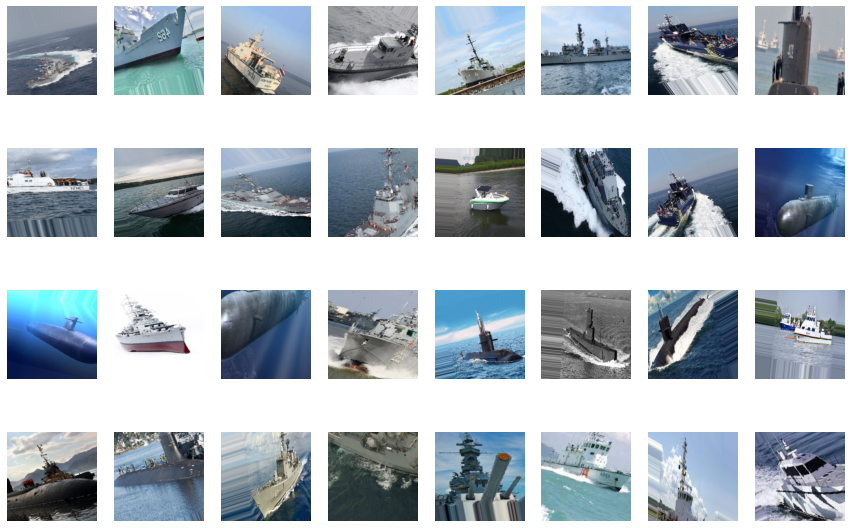

In [ ]:
batch = train_generator.next()
img_train = (batch[0]*255).astype(np.uint8)
print(batch[0].shape)

fig, ax = plt.subplots(nrows=4, ncols=8, figsize=(15, 10))

img_idx = 0
for i in range(4):
    for j in range(8):
        ax[i, j].imshow(batch[0][img_idx])
        ax[i, j].axis('off')
        img_idx += 1

### 10.2.2 Create Optimizer, parameters

In [ ]:
# Create Optimizer
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#Define training Generator Parameter
EP = 50 #Number of Epoches
step_size_train = train_generator.n // train_generator.batch_size
step_size_val = val_generator.n // val_generator.batch_size
print(step_size_train)
print(step_size_val)


3
3


### 10.2.3 Training, Validation, plot accuracy, loss

In [ ]:
history=model.fit_generator(generator=train_generator,
                            steps_per_epoch=step_size_train,
                            validation_data = val_generator,
                            validation_steps = step_size_val,
                            epochs=EP,
                            verbose = 1)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  
Epoch 1/50
3/3 [==============================] - 41s 13s/step - loss: 2.2922 - accuracy: 0.4375 - val_loss: 3.7892 - val_accuracy: 0.3623
Epoch 2/50
3/3 [==============================] - 28s 14s/step - loss: 0.7302 - accuracy: 0.7538 - val_loss: 1.5535 - val_accuracy: 0.3913
Epoch 3/50
3/3 [==============================] - 34s 12s/step - loss: 0.5550 - accuracy: 0.7396 - val_loss: 1.9703 - val_accuracy: 0.3333
Epoch 4/50
3/3 [==============================] - 28s 14s/step - loss: 0.7930 - accuracy: 0.6154 - val_loss: 0.8083 - val_accuracy: 0.5507
Epoch 5/50
3/3 [==============================] - 27s 8s/step - loss: 0.5230 - accuracy: 0.8000 - val_loss: 1.4091 - val_accuracy: 0.6377
Epoch 6/50
3/3 [==============================] - 35s 12s/step - loss: 0.2427 

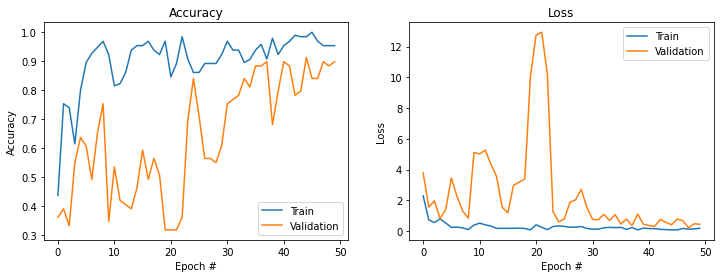

In [ ]:
# Performance Visualization
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# View Accuracy (Training, Validation)
ax[0].plot(history.history["accuracy"], label="Train_acc")
ax[0].plot(history.history["val_accuracy"], label="Validate_acc")
ax[0].set_title("Accuracy")
ax[0].set_xlabel("Epoch #")
ax[0].set_ylabel("Accuracy")
ax[0].legend(["Train", "Validation"], loc="best")

# View Loss (Training, Validation)
ax[1].plot(history.history['loss'], label="Train_loss")
ax[1].plot(history.history['val_loss'], label="Validate_loss")
ax[1].set_title("Loss")
ax[1].set_xlabel("Epoch #")
ax[1].set_ylabel("Loss")
ax[1].legend(["Train", "Validation"], loc="best")

plt.show()

## 10.3 Model testing and Performance visualize

### 10.3.1 Create ImageDataGenerator (Test) and Predict Results

In [ ]:
# Initial test generator
test_datagen= ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
                                                ship_test,
                                                class_mode="categorical",
                                                target_size=(224, 224), color_mode="rgb",
                                                shuffle=False, seed=42,
                                                batch_size=1)

Found 15 images belonging to 3 classes.


In [ ]:
#Get class id for y_real_class
y_true = test_generator.classes
y_true

array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2], dtype=int32)

In [ ]:
#predict 1 image at a time for total predict images = len(y_true) # number of real class
test_generator.reset()
pred_prob = []
for i in range(len(y_true)):
    pred = model.predict(test_generator.next()[0],verbose=0)
    pred_prob.append(np.array(pred[0]))

pred_prob

[array([1.2091619e-01, 3.8575814e-05, 8.7904519e-01], dtype=float32),
 array([0.99020493, 0.00197264, 0.00782245], dtype=float32),
 array([9.9378783e-01, 1.6501851e-04, 6.0470714e-03], dtype=float32),
 array([0.74973625, 0.07906598, 0.17119774], dtype=float32),
 array([4.933346e-03, 9.948532e-01, 2.134463e-04], dtype=float32),
 array([1.8251538e-10, 1.0000000e+00, 3.3418113e-14], dtype=float32),
 array([1.1444699e-06, 9.9999881e-01, 3.4274144e-08], dtype=float32),
 array([3.4103842e-04, 9.9965608e-01, 2.8566603e-06], dtype=float32),
 array([1.4536041e-08, 1.0000000e+00, 1.2521705e-11], dtype=float32),
 array([3.0350534e-03, 9.9691355e-01, 5.1329724e-05], dtype=float32),
 array([5.3070527e-01, 1.8208916e-04, 4.6911263e-01], dtype=float32),
 array([0.29724798, 0.00361791, 0.6991342 ], dtype=float32),
 array([4.1088742e-01, 1.0266588e-04, 5.8900988e-01], dtype=float32),
 array([0.6998549 , 0.02426381, 0.2758813 ], dtype=float32),
 array([5.9963085e-02, 3.7679137e-04, 9.3966013e-01], dtype

In [ ]:
#Get classID from max prob(pred_prob)
df_pred = pd.DataFrame(pred_prob)
df_class = df_pred.idxmax(axis=1)
df_class

0     2
1     0
2     0
3     0
4     1
5     1
6     1
7     1
8     1
9     1
10    0
11    2
12    2
13    0
14    2
dtype: int64

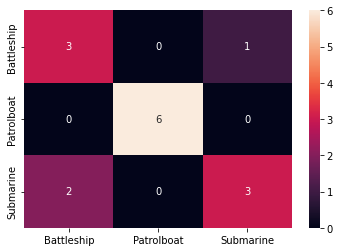

In [ ]:
class_names = ["Battleship", "Patrolboat", "Submarine"]
class_dict = dict(enumerate(class_names))

# Calculate confusion matrix, classification report between y_true and df_class
con_mat = confusion_matrix(y_true, df_class)
con_mat_df = pd.DataFrame(con_mat)
con_mat_df.rename(index=class_dict, columns=class_dict, inplace=True)
sns.heatmap(con_mat_df, annot=True)
plt.show()

In [ ]:
print(classification_report(y_true, df_class, target_names=class_names))

              precision    recall  f1-score   support

  Battleship       0.60      0.75      0.67         4
  Patrolboat       1.00      1.00      1.00         6
   Submarine       0.75      0.60      0.67         5

    accuracy                           0.80        15
   macro avg       0.78      0.78      0.78        15
weighted avg       0.81      0.80      0.80        15



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=21d67d38-3397-426c-9c2e-e84dd6566cd2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>